# Galaxy Zoo star-formation rate data analysis activity
## Example analysis

This activity uses the data for Fig. 6 and 7 of [this paper](https://arxiv.org/pdf/1703.02053). It compares two different estimates of the star-formation rate for samples of galaxies with different numbers of spiral arms (see Figure. 11 in this [other paper](https://arxiv.org/pdf/1607.01019)).

Star-formation rates (SFRs) are estimated directly from far-UV (FUV) and mid-infrared (MIR; 22 micron) photometry. Stellar mass is used to determine the specific star-formation rate (sSFR).

The provided data does not perfectly match that used in the above papers, so you will not be able to exactly reproduce their plots and results, but they should be close.

One could:
* Propagate errors for eqns. (4), (5), (6), log(sSFR) and also for log(SFR_FUV/SFR_22).
* Show that the scatter in the distribution is significantly larger than the propagated uncertainties, i.e. there is intrinsic variation in the sSFR of galaxies.
* Use different sized samples to demonstrate that the error on the mean goes as 1/sqrt(N), and that it has a Gaussian distribution, even when the original quantity is non-Gaussian.
* Test for statistical differences in mean log(sSFR) and log(SFR_FUV/SFR_22) for galaxies with different numbers of spiral arms. Maybe you could first use resampled distributions of different sizes, then show that the results are the similar if you propagate the Gaussian error on the mean.
* You could then introduce bootstrap resampling and show it gives the same result.
* As a more compelling case for the bootstrap, you could consider a more complicated statistic, e.g. the median or the skew of the distribution, and see if it changes significantly with spiral arm number.
 

In [9]:
import numpy as np    
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('gz_data.csv')
print(len(data))

2986


In [3]:
data

,dr7id,m,logL_FUV,logL_FUV_err,logL_22,logL_22_err,logMstar,logMstar_err
0,588015509830762647,3,9.93,0.02,9.28,0.05,10.90,0.12
1,588015510362390600,2,9.63,0.02,8.74,0.04,10.54,0.12
2,587729774758199429,2,8.78,0.05,9.42,0.05,10.22,0.09
3,587722981755977976,1,9.48,0.02,9.24,0.07,10.93,0.09
4,587729778521604125,2,8.85,0.04,9.34,0.05,10.93,0.08
...,...,...,...,...,...,...,...,...
2981,587745541053480977,2,9.08,0.06,8.67,0.07,10.62,0.07
2982,587745541056757944,3,9.40,0.06,9.03,0.07,10.69,0.09
2983,587745541057085533,3,9.94,0.03,9.54,0.05,10.99,0.11
2984,587745541057937469,2,9.44,0.05,9.32,0.07,10.44,0.09


One could do various things with this dataset before adding the complication of converting to star-formation rates, etc.

### Calculate SFR quantities from the data

We use the equations and information given in the paper, and propogate uncertainties.

Uncertainties are propogated using $u^2(f) = \sum_i \left(\frac{\partial f}{dx_i}\right)^2 u^2(x_i)$, for $f(x_i)$.

#### Star formation rates from luminositites

From Eqn. 4, $SFR_\textrm{FUV} = 10^{-9.69} L_\textrm{FUV}$, where the luminosity is in solar units ($L_{\odot}$) and the SFR is in solar masses per year ($M_{\odot}\,\textrm{yr}^{-1}$).

Taking the logarithm (base 10), $\log(SFR_\textrm{FUV}) = \log(L_\textrm{FUV}) - 9.69$.

The uncertainty on this is simply, $u[\log(SFR_\textrm{FUV})] = u[\log(L_\textrm{FUV})]$.

We are given $\log(L_\textrm{FUV})$ and its uncertainty in columns `logL_FUV` and `log_FUV_err` of the table.

Similarly, Eqn. 5, together with the value of $\eta$ and small IMF correction specified in the following paragraph, gives,

$\log(SFR_\textrm{22}) = \log(L_\textrm{22}) - 9.125 + \log(1 - 0.17) - 0.03$.

with uncertainty, $u[\log(SFR_\textrm{22})] = u[\log(L_\textrm{22})]$.

We are given $\log(L_\textrm{22})$ and its uncertainty in columns `logL_22` and `log_22_err` of the table.

In each case we have neglected the uncertainty on the luminosity to SFR calibrations.

#### Total star formation rate

For the total SFR we have, from Eqn. 6, $\log(SFR_\textrm{total}) = \log(SFR_\textrm{FUV} + SFR_\textrm{22})$.

Calculating the uncertainty takes some care, but gives, $u[\log(SFR_\textrm{total})] = \frac{1}{SFR_\textrm{total}} \sqrt{\big(SFR_\textrm{FUV}\cdot u[\log(SFR_\textrm{FUV})]\big)^2 + \big(SFR_\textrm{22}\cdot u[\log(SFR_\textrm{22})]\big)^2}$.

#### Specific star formation rate

We now have that $sSFR = SFR_\textrm{total} / M_*$, which means that $\log(sSFR) = \log(SFR_\textrm{total}) - \log(M_*)$, where $sSFR$ is in units of $\textrm{yr}^{-1}$, $SFR$ is in $M_\odot\,\textrm{yr}^{-1}$, and $M_*$ is the stellar mass in $M_\odot$.

Therefore, $u[\log(sSFR)] = \sqrt{u[\log(SFR_\textrm{total})]^2 + u[\log(M_*)]^2}$.

We are given $\log(M_*)$ and its uncertainty in columns `logMStar` and `logMstar_err` of the table.

#### Residual sSFR

Eqns. 7 and 8 define $\log(sSFR_\textrm{expected}) = -0.49 \log(M_*) − 5.06$ and $\log(sSFR_\textrm{residual}) = \log(sSFR) - \log(sSFR_\textrm{expected})$.

Assuming no uncertainty in the expected sSFR, then $u[\log(sSFR_\textrm{residual})] = u[\log(sSFR)]$.

#### FUV versus MIR SFR ratio

In Sec. 3.2, the SFR in the FUV and MIR are compared using $\log(SFR_\textrm{FUV} / SFR_\textrm{22}) = \log(SFR_\textrm{FUV}) - \log(SFR_\textrm{22})$.

Therefore, $u[\log(SFR_\textrm{FUV} / SFR_\textrm{22})] = \sqrt{u[\log(SFR_\textrm{FUV})]^2 + u[\log(SFR_{22})]^2}$.

The code below adds all these quantities to the data table.

In [4]:
data['logSFR_FUV'] = data['logL_FUV'] - 9.69
data['logSFR_FUV_err'] = data['logL_FUV_err']
data['logSFR_22'] = data['logL_22'] - 9.125 + np.log10(1 - 0.17) - 0.03
data['logSFR_22_err'] = data['logL_22_err']
SFR_FUV = 10**data['logSFR_FUV']
SFR_22 = 10**data['logSFR_22']
SFR = SFR_FUV + SFR_22
data['logSFR'] = np.log10(SFR)
data['logSFR_err'] = np.sqrt((SFR_FUV * data['logSFR_FUV_err'])**2 + (SFR_22 * data['logSFR_22_err'])**2) / SFR
data['logsSFR'] = data['logSFR'] - data['logMstar']
data['logsSFR_err'] = np.sqrt(data['logSFR_err']**2 + data['logMstar_err']**2)
logsSFR_expected = -0.49 * data['logMstar'] - 5.06
data['logsSFR_residual'] = data['logsSFR'] - logsSFR_expected
data['logSFR_ratio'] = data['logSFR_FUV'] - data['logSFR_22']
data['logSFR_ratio_err'] = np.sqrt(data['logSFR_FUV_err']**2 + data['logSFR_22_err']**2)

Get the list of arm numbers, $m$.

In [5]:
m_list = np.unique(data['m'])
print(m_list)

['1' '2' '3' '4' '5+']


Approximately reproduce Fig. 6.

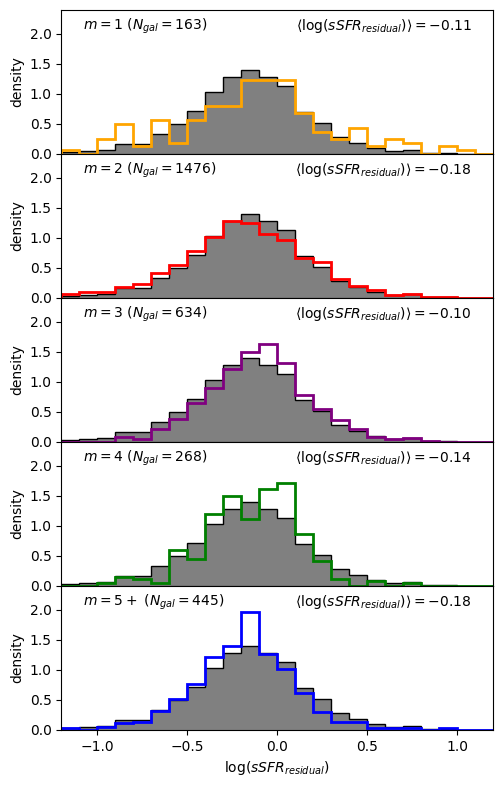

In [6]:
colours = ['orange', 'red', 'purple', 'green', 'blue']
fig, axarr = plt.subplots(5, 1, figsize=(5, 8), sharex=True, sharey=True)
for i, m in enumerate(m_list):
    ax = axarr[i]
    ax.hist(data['logsSFR_residual'], range=(-1.5, 1.5), bins=30, color='grey', density=True)
    ax.hist(data['logsSFR_residual'], range=(-1.5, 1.5), bins=30, color='black', histtype='step', density=True)
    lsr_m = data['logsSFR_residual'][data['m'] == m]
    ax.hist(lsr_m, range=(-1.5, 1.5), bins=30, histtype='step', density=True, linewidth=2, color=colours[i])
    ax.set_ylabel('density')
    ax.text(0.05, 0.95, f'$m={m}$ ($N_{{gal}}={len(lsr_m)}$)', ha='left', va='top', transform=ax.transAxes)
    mean = lsr_m.mean()
    ax.text(0.95, 0.95, f'$\\left<\\log(sSFR_{{residual}})\\right> = {mean:.2f}$', ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$\\log(sSFR_{residual})$')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 2.4)
plt.show()

Approximately reproduce Fig. 7.

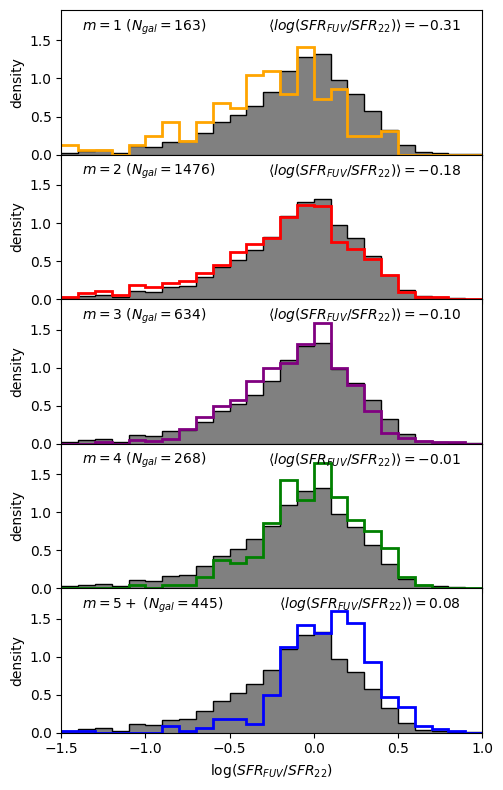

In [7]:
fig, axarr = plt.subplots(5, 1, figsize=(5, 8), sharex=True, sharey=True)
for i, m in enumerate(m_list):
    ax = axarr[i]
    ax.hist(data['logSFR_ratio'], range=(-2.5, 1), bins=35, color='grey', density=True)
    ax.hist(data['logSFR_ratio'], range=(-2.5, 1), bins=35, color='black', histtype='step', density=True)
    lsr_m = data['logSFR_ratio'][data['m'] == m]
    ax.hist(lsr_m, range=(-2.5, 1), bins=35, histtype='step', density=True, linewidth=2, color=colours[i])
    ax.set_ylabel('density')
    ax.text(0.05, 0.95, f'$m={m}$ ($N_{{gal}}={len(lsr_m)}$)', ha='left', va='top', transform=ax.transAxes)
    mean = lsr_m.mean()
    ax.text(0.95, 0.95, f'$\\left<log(SFR_{{FUV}}/SFR_{{22}})\\right> = {mean:.2f}$', ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$\\log(SFR_{FUV}/SFR_{22})$')
ax.set_xlim(-1.5, 1)
ax.set_ylim(0, 1.9)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

The repeated gray histogram in Fig. 6 shows that galaxies in the sample have a distribution of residual specific star formation rates. Could the distribution just be due to the random errors?

Let's compare the standard deviation of the measured distributions with the average error...

In [8]:
std = data['logsSFR_residual'].std()
mean_err = data['logsSFR_err'].mean()
print(std, mean_err, std / mean_err)

0.3227852610938433 0.1050395743517081 3.072987139238101


The standard deviation of the distribution is more than three times larger than would be expected from the errors, so it seems that galaxies really do vary in their residual sSFR.